In [1]:
import pandas as pd
import datetime
import random
import pytz

from sqlalchemy import create_engine

from password import hoop_pwd
pwd = hoop_pwd.password

%matplotlib inline

from nba_seer import *

modules imported
functions defined


In [2]:
# create sql conn and load game stats logs ----------------------

conn = create_engine('mysql+pymysql://root:%s@118.190.202.87:3306/nba_stats' % pwd)
game_stats_logs = pd.read_sql_table('game_stats_logs', conn)
game_stats_logs = game_stats_logs[game_stats_logs['GAME_TYPE'] != 'all_star']

print(str(len(game_stats_logs)) + ' player stats loaded.')

185249 player stats loaded.


In [3]:
# load player list ----------------------

all_players = nba_py.player.PlayerList(season='2017-18').info()

print('players list loaded')

players list loaded


In [4]:
def get_score(row):
    player_id = row['PERSON_ID']
    game_id = row['GAME_ID']
    stats = game_stats_logs[(game_stats_logs['PLAYER_ID'] == player_id) & 
                            (game_stats_logs['GAME_ID'] == game_id)].copy()
    #print(stats)
    stats['SCO'] = stats['PTS'] * 1 + stats['AST'] * 1.5 + \
    stats['OREB'] * 1 + stats['DREB'] * 0.7 + \
    stats['STL'] * 2 + stats['BLK'] * 1.8 + stats['TO'] * -1 + \
    stats['FGM'] * 0.4 + (stats['FGA'] - stats['FGM']) * -1 + stats['FG3M'] * 0.5
    return stats['SCO'].max()

In [5]:
def test_result(players):
    diff_pct = players['SCO_DIFF_PCT'].describe().to_frame()
    diff_sco = players['SCO_DIFF'].describe().to_frame()
    ans = pd.concat([diff_sco, diff_pct], axis=1)
    return ans

In [6]:
def factor_cov(players):
    cov_diff = pd.DataFrame()
    #cov_diff['cov'] = abs(players[['MIN_COV_20', 'SCO_COV_20']].mean(axis = 1))
    cov_diff['cov'] = abs(players['MIN_COV_20'] * players['SCO_COV_20'])
    cov_diff['diff_pct'] = abs(players['SCO_DIFF_PCT'])
    cov_diff.plot(x='cov', y='diff_pct', kind='scatter', grid=True, figsize=(10, 7))
    cov_diff_pct_corr = cov_diff['cov'].corr(cov_diff['diff_pct'])
    print('the corr between cov and different percantage is: ', cov_diff_pct_corr)

In [21]:
def diff_distribution(players, rg, interval):
    diff_pct = players[abs(players['SCO_DIFF_PCT']) <= rg]['SCO_DIFF_PCT'].abs()
    bins = []
    for i in range(int(rg/interval)):
        bins.append(i*interval)
    pct_cut = pd.cut(diff_pct, bins)
    pct_cut_df = pd.value_counts(pct_cut).to_frame().rename(columns={'SCO_DIFF_PCT': 'count'})
    pct_cut_df = pct_cut_df.sort_index(axis=0)
    pct_cut_df.plot(kind='bar', figsize=(15, 7))
    print('data in range:', len(diff_pct)/len(players))

In [8]:
game_date = game_stats_logs['GAME_DATE_EST'].drop_duplicates().apply(lambda x: x[:10])

In [9]:
players = pd.DataFrame()
for i in random.sample(list(game_date), 5):
    j = datetime.datetime.strptime(i, "%Y-%m-%d").date()
    games = get_games(j)
    players = players.append(get_players_p(games, game_stats_logs))
    print(str(j) + ' complete!')
else:
    print(len(players), ' players total!')

2013-11-27 complete!
2012-12-07 complete!
2017-02-09 complete!
2016-05-05 complete!
2014-11-03 complete!
941  players total!


In [10]:
players = get_exp_sco(players, game_stats_logs)

players['ACT_SCO'] = players.apply(get_score, axis = 1)
players['SCO_DIFF'] = players['EXP_SCO'] - players['ACT_SCO']
players['SCO_DIFF_PCT'] = players['SCO_DIFF'] / players['ACT_SCO']
print('test data loaded!')

5games days complete!
days rest complete!
ma20 complete!
ma10 complete!
ma5 complete!
min20 complete!
min10 complete!
min5 complete!
min_cov_20 complete!
sco_cov_20 complete!
sco cov less than 0 droped!
all done!
test data loaded!


In [11]:
players = players[(players['ACT_SCO'] != 0) & (players['ACT_SCO'].notnull())]

In [12]:
players.sort_values('ACT_SCO')

,PERSON_ID,TEAM_ID,Location,GAME_ID,Against_Team_ID,5_g_d,d_rest,MA_20,MA_10,MA_5,MIN_20,MIN_10,MIN_5,MIN_COV_20,SCO_COV_20,EXP_SCO,ACT_SCO,SCO_DIFF,SCO_DIFF_PCT
107,201568,1610612743,HOME,0021400047,1610612758,15.0,1084.0,22.39,24.52,20.36,24.22,16.17,16.72,0.378,0.469,11.86,-5.6,17.46,-3.117857
67,203105,1610612744,AWAY,0021200272,1610612751,12.0,1780.0,18.53,21.61,20.11,16.84,17.24,17.10,0.251,0.501,9.52,-5.3,14.82,-2.796226
217,201600,1610612745,AWAY,0021200278,1610612759,12.0,1781.0,23.59,25.23,33.05,32.29,32.28,30.74,0.179,0.415,24.08,-5.1,29.18,-5.721569
9,201229,1610612766,HOME,0021300215,1610612754,10.0,1425.0,10.48,12.13,9.88,14.07,13.09,7.78,0.600,1.258,3.50,-4.3,7.80,-1.813953
68,202337,1610612740,AWAY,0021400045,1610612763,15.0,1088.0,15.53,14.31,9.56,16.45,13.36,9.05,0.549,0.947,4.73,-3.2,7.93,-2.478125
44,202498,1610612760,AWAY,0021400044,1610612751,16.0,1084.0,9.50,12.96,20.49,17.53,23.14,23.06,0.515,1.120,8.45,-3.2,11.65,-3.640625
327,1897,1610612752,AWAY,0021300227,1610612746,13.0,1425.0,16.16,15.29,6.23,22.25,20.76,13.01,0.332,0.731,6.51,-2.5,9.01,-3.604000
16,1891,1610612738,AWAY,0021200270,1610612755,11.0,1780.0,19.54,21.14,20.67,28.84,32.01,34.43,0.195,0.397,18.04,-2.5,20.54,-8.216000
274,202365,1610612747,AWAY,0021200280,1610612760,32.0,1780.0,18.13,27.69,20.06,9.80,9.12,11.04,0.256,0.835,6.09,-2.5,8.59,-3.436000
136,101111,1610612765,HOME,0021300220,1610612741,37.0,1425.0,16.78,27.17,39.43,11.20,10.20,12.59,0.532,1.121,8.75,-2.0,10.75,-5.375000


In [13]:
players_t = players[players['5_g_d'] < 20]
players_t = players_t[players_t['SCO_COV_20'] < 0.6]
players_t = players_t[players_t['MIN_COV_20'] < 0.25]
players_t.sort_values('ACT_SCO')

,PERSON_ID,TEAM_ID,Location,GAME_ID,Against_Team_ID,5_g_d,d_rest,MA_20,MA_10,MA_5,MIN_20,MIN_10,MIN_5,MIN_COV_20,SCO_COV_20,EXP_SCO,ACT_SCO,SCO_DIFF,SCO_DIFF_PCT
217,201600,1610612745,AWAY,0021200278,1610612759,12.0,1781.0,23.59,25.23,33.05,32.29,32.28,30.74,0.179,0.415,24.08,-5.1,29.18,-5.721569
16,1891,1610612738,AWAY,0021200270,1610612755,11.0,1780.0,19.54,21.14,20.67,28.84,32.01,34.43,0.195,0.397,18.04,-2.5,20.54,-8.216000
130,201577,1610612740,HOME,0021200275,1610612763,10.0,1780.0,26.28,30.48,31.17,27.44,26.45,25.55,0.231,0.441,21.56,-0.7,22.26,-31.800000
98,2733,1610612764,AWAY,0021200273,1610612737,14.0,1781.0,16.09,16.09,17.57,20.57,20.57,20.33,0.168,0.452,9.44,-0.5,9.94,-19.880000
215,202718,1610612745,AWAY,0021200278,1610612759,14.0,1781.0,22.59,26.73,28.69,37.94,38.08,37.96,0.137,0.528,27.44,-0.1,27.54,-275.400000
8,201196,1610612766,HOME,0021300215,1610612754,8.0,1425.0,23.75,23.93,15.68,21.24,21.16,23.46,0.219,0.493,12.88,0.8,12.08,15.100000
8,202687,1610612761,HOME,0041500212,1610612748,11.0,535.0,23.88,25.17,22.67,17.84,18.26,17.28,0.233,0.376,11.82,1.1,10.72,9.745455
191,2217,1610612766,AWAY,0021200277,1610612749,10.0,1780.0,17.22,15.70,15.94,27.28,26.55,25.65,0.215,0.405,11.99,2.0,9.99,4.995000
7,202335,1610612761,HOME,0041500212,1610612748,11.0,535.0,17.79,14.99,11.16,26.04,24.53,24.09,0.187,0.592,10.13,2.1,8.03,3.823810
79,2749,1610612742,HOME,0021400046,1610612738,13.0,1084.0,23.30,23.84,19.49,25.65,25.52,26.79,0.187,0.362,16.03,2.2,13.83,6.286364


In [14]:
test_result(players_t)

,SCO_DIFF,SCO_DIFF_PCT
count,273.000000,273.000000
mean,0.166007,-0.812491
std,9.681970,16.920673
min,-34.430000,-275.400000
25%,-6.110000,-0.242718
50%,0.550000,-0.005830
75%,6.480000,0.385549
max,29.180000,15.100000


the corr between cov and different percantage is:  0.0140055618412


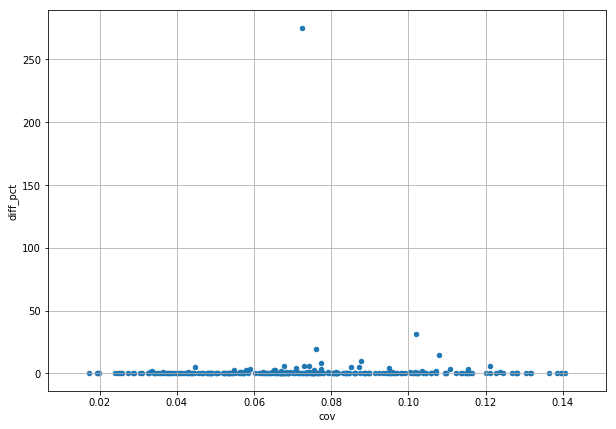

In [15]:
factor_cov(players_t)

data in range: 0.9633699633699634


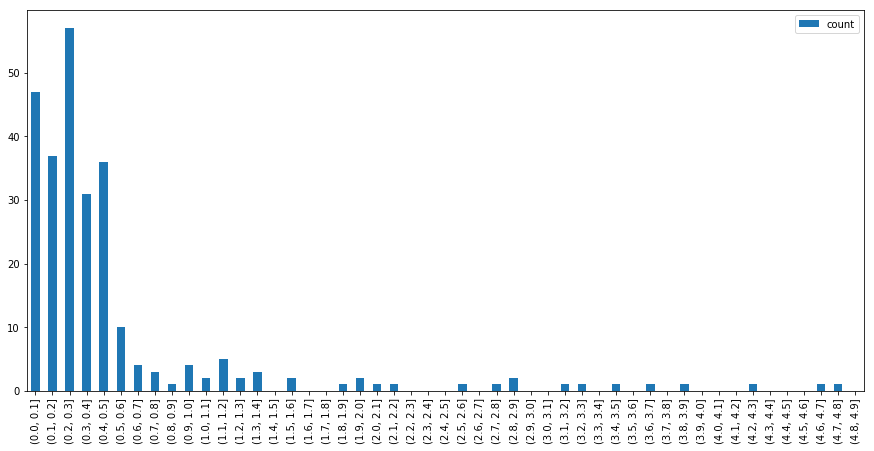

In [22]:
diff_distribution(players_t, 5, 0.1)